
# # Intensity Analysis using NLP - Full Implementation


# ## 1. Data Loading and Preprocessing

In [1]:
# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download(['punkt', 'stopwords', 'wordnet'])

[nltk_data] Downloading package punkt to C:\Users\PRAMOD
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\PRAMOD
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\PRAMOD
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

# Load datasets
sadness = pd.read_csv('sadness.csv')
happiness = pd.read_csv('happiness.csv', skip_blank_lines=True).dropna()
angriness = pd.read_csv('angriness.csv')

In [4]:

# Combine datasets
df = pd.concat([
    sadness[['content', 'intensity']],
    happiness[['content', 'intensity']],
    angriness[['content', 'intensity']]
]).sample(frac=1).reset_index(drop=True)


In [5]:
# Clean data
def clean_text(text):
    # Handle list-like strings
    text = re.sub(r"[\[\]']", '', str(text))
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase
    text = text.lower()
    return text.strip()

df['clean_text'] = df['content'].apply(clean_text)

In [6]:

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['clean_text'].apply(preprocess_text)


# ## 2. Exploratory Data Analysis (EDA)

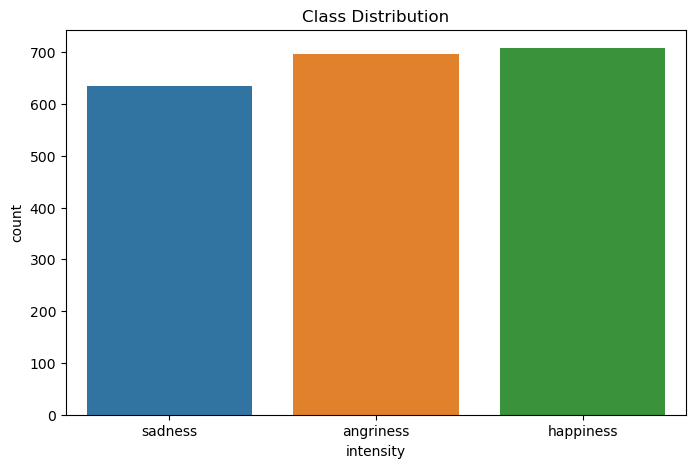

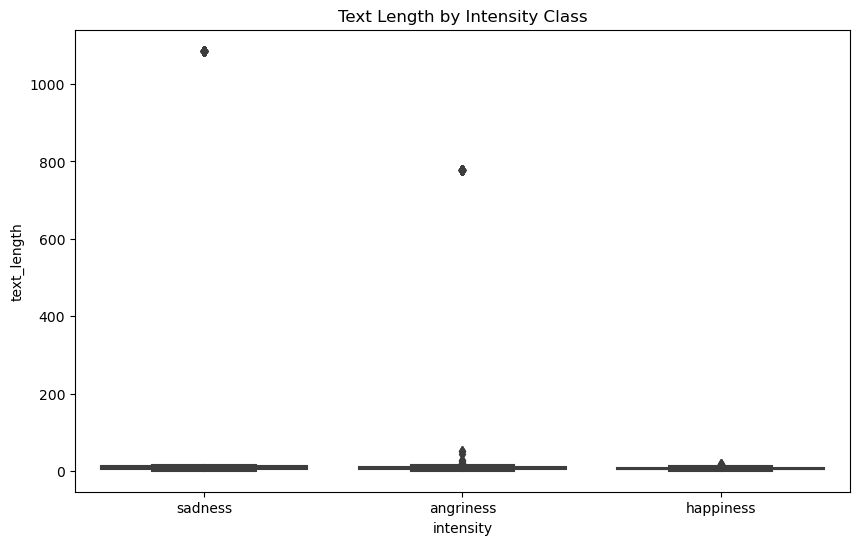

In [7]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns

# Class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='intensity', data=df)
plt.title('Class Distribution')
plt.show()

# Text length analysis
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.boxplot(x='intensity', y='text_length', data=df)
plt.title('Text Length by Intensity Class')
plt.show()

# ## 3. Feature Engineering


In [8]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['processed_text'])
y = df['intensity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# %% [markdown]
# ## 3. Feature Engineering

# %%
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['processed_text'])
y = df['intensity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# ## 4. Model Training & Evaluation



In [10]:
# Logistic Regression with Grid Search
params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr = LogisticRegression(max_iter=1000)
grid = GridSearchCV(lr, params, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.78
              precision    recall  f1-score   support

   angriness       0.82      0.80      0.81       139
   happiness       0.75      0.79      0.77       142
     sadness       0.77      0.75      0.76       127

    accuracy                           0.78       408
   macro avg       0.78      0.78      0.78       408
weighted avg       0.78      0.78      0.78       408



# ## 5. Model Deployment Plan

In [12]:
# %%
import joblib

# Create final pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('classifier', LogisticRegression(C=10, penalty='l2', solver='liblinear'))
])

# Train on full dataset
pipeline.fit(df['processed_text'], df['intensity'])

# Save model
joblib.dump(pipeline, 'intensity_classifier.pkl')

# Prediction function
def predict_intensity(text):
    model = joblib.load('intensity_classifier.pkl')
    cleaned_text = preprocess_text(clean_text(text))
    return model.predict([cleaned_text])[0]

# Test prediction
sample_text = "I'm absolutely delighted with this wonderful product!"
print(f"Prediction: {predict_intensity(sample_text)}")

Prediction: happiness
